# Cat Dog Image datasets
* Cat dog dataset is from Kaggle (https://www.kaggle.com/datasets/chetankv/dogs-cats-images)
* The workflow code is adapted from a Machine Learning with PyTorch and Scikit-Learn

In [1]:
import torch
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
cat_path = pathlib.Path('../../../dataset_kaggle/cat_dog_dataset/dataset/training_set/cats')
dog_path = pathlib.Path('../../../dataset_kaggle/cat_dog_dataset/dataset/training_set/dogs')
cat_files = sorted([str(path) for path in cat_path.glob('*.jpg')])
dog_files = sorted([str(path) for path in dog_path.glob('*.jpg')])

## Visualize image

In [3]:
def visual_multi_img(img_files, title_list, row, col, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    for i, img in enumerate(img_files):
        img = Image.open(img_files[i])
        ax = fig.add_subplot(row, col, i+1)
        ax.imshow(img)
        ax.set_title(title_list[i])
        ax.axis('off')

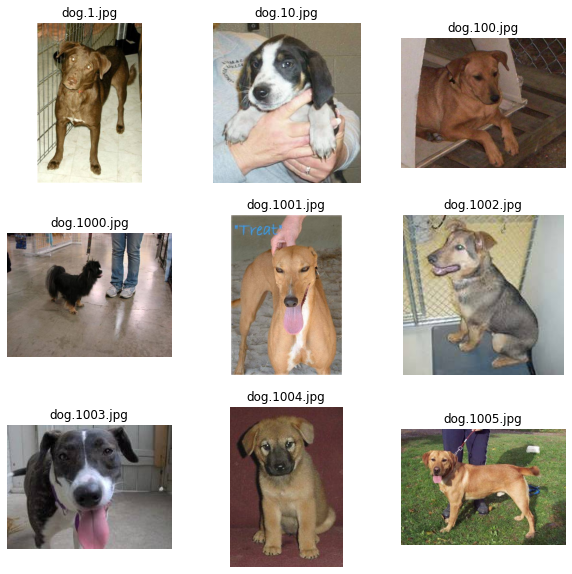

In [4]:
visual_multi_img(dog_files[0:9],[file.split('/')[8] for file in dog_files[0:9]], 3, 3)

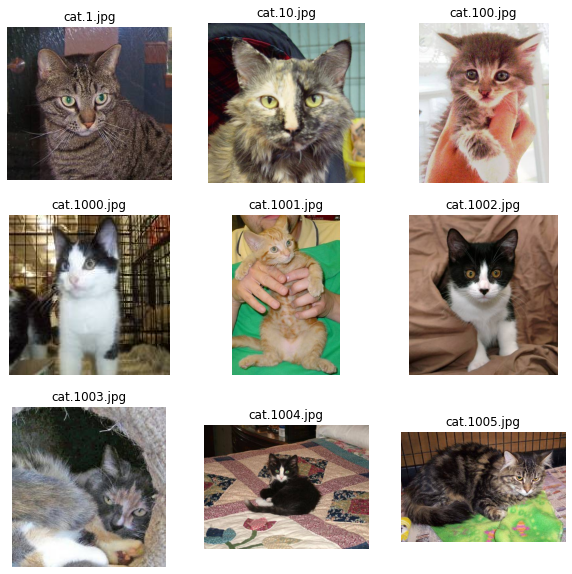

In [5]:
visual_multi_img(cat_files[0:9],[file.split('/')[8] for file in cat_files[0:9]], 3, 3)

## Create ImageDataset class with label and transform to size (224,224)
* cat is labled as 0, dog is labeled as 1

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
])

In [7]:
class ImageDataset():
    def __init__(self, img_files, labels, transform=None):
        self.img_files = img_files
        self.transform = transform
        self.labels = labels
    def __len__(self):
        return len(self.img_files)
    def __getitem__(self, idx):
        img = Image.open(self.img_files[idx])
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [8]:
img_dataset = ImageDataset( cat_files + dog_files, [0]*len(cat_files) + [1]*len(dog_files), transform)

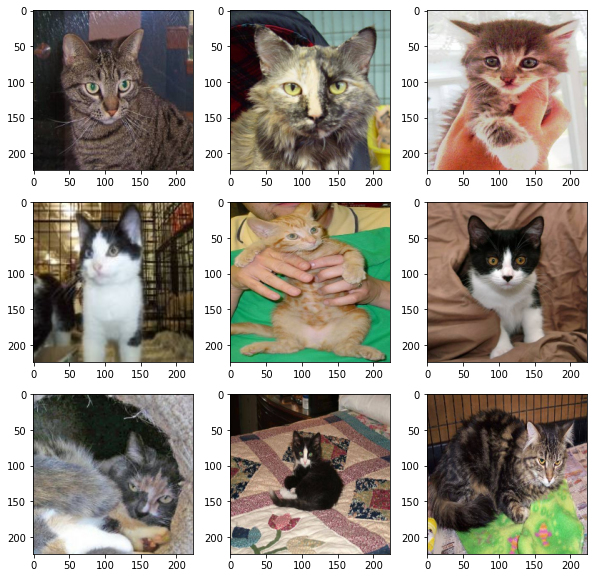

In [9]:
fig = plt.figure(figsize = (10, 10))
for i, img in enumerate(img_dataset):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(img[0].numpy().transpose((1,2,0)))
    if i == 8:
        break

## CNN of CatDogClassifier

This network has two convolutional layers, each followed by a ReLU activation and a max pooling layer, which are then flattened and passed through two fully connected layers. The final output is a softmax over two classes, corresponding to whether the input image is a cat or a dog.

In [10]:
class CatDogClassifier(nn.Module):
    def __init__(self):
        super(CatDogClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=32*56*56, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = x.view(-1, 32*56*56)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

In [11]:
# define model and optimizer
model = CatDogClassifier()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Linear-5                  [-1, 256]      25,690,368
            Linear-6                    [-1, 2]             514
Total params: 25,695,970
Trainable params: 25,695,970
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 11.49
Params size (MB): 98.02
Estimated Total Size (MB): 110.08
----------------------------------------------------------------


In [13]:
dataloader = DataLoader(img_dataset, batch_size=32, shuffle=True)

In [14]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

In [15]:

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(dataloader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and update weights
        loss.backward()
        optimizer.step()

        # Print status every 100 batches
        if i % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(dataloader)}, Loss {loss.item():.4f}")


Epoch 1/10, Batch 1/250, Loss 0.7006
Epoch 1/10, Batch 101/250, Loss 0.6806
Epoch 1/10, Batch 201/250, Loss 0.6534
Epoch 2/10, Batch 1/250, Loss 0.5749
Epoch 2/10, Batch 101/250, Loss 0.5557
Epoch 2/10, Batch 201/250, Loss 0.5320
Epoch 3/10, Batch 1/250, Loss 0.5655
Epoch 3/10, Batch 101/250, Loss 0.6056
Epoch 3/10, Batch 201/250, Loss 0.5543
Epoch 4/10, Batch 1/250, Loss 0.4319
Epoch 4/10, Batch 101/250, Loss 0.2885
Epoch 4/10, Batch 201/250, Loss 0.3430
Epoch 5/10, Batch 1/250, Loss 0.2355
Epoch 5/10, Batch 101/250, Loss 0.1932
Epoch 5/10, Batch 201/250, Loss 0.1785
Epoch 6/10, Batch 1/250, Loss 0.0859
Epoch 6/10, Batch 101/250, Loss 0.0990
Epoch 6/10, Batch 201/250, Loss 0.1024
Epoch 7/10, Batch 1/250, Loss 0.0436
Epoch 7/10, Batch 101/250, Loss 0.0082
Epoch 7/10, Batch 201/250, Loss 0.0162
Epoch 8/10, Batch 1/250, Loss 0.0401
Epoch 8/10, Batch 101/250, Loss 0.0468
Epoch 8/10, Batch 201/250, Loss 0.0862
Epoch 9/10, Batch 1/250, Loss 0.0034
Epoch 9/10, Batch 101/250, Loss 0.0073
Epoc

## Test model using test dataset

In [16]:
testcat_path = pathlib.Path('../../../dataset_kaggle/cat_dog_dataset/dataset/test_set/cats')
testdog_path = pathlib.Path('../../../dataset_kaggle/cat_dog_dataset/dataset/test_set/dogs')
testcat_files = sorted([str(path) for path in testcat_path.glob('*.jpg')])
testdog_files = sorted([str(path) for path in testdog_path.glob('*.jpg')])

In [17]:
test_img_dataset = ImageDataset( testcat_files + testdog_files, [0]*len(testcat_files) + [1]*len(testdog_files), transform)

In [18]:

testdataloader = DataLoader(test_img_dataset, batch_size=32)

In [19]:
# Evaluate the model
model.eval()

CatDogClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [30]:
# Make predictions
with torch.no_grad():
    total = 0
    correct = 0
    for images, labels in testdataloader:
        outputs = model(images)
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy on test dataset: {:.2f}%'.format(accuracy))

Accuracy on test dataset: 71.05%


## Predict image

In [32]:
figfile = './02inoutput/KOA_Nassau_2697x1517.jpg'
image = Image.open(figfile)
image = transform(image)

with torch.no_grad():
    output = model(image.unsqueeze(0))
    predicted = torch.argmax(output.data, 1)
    print(predicted)

tensor([1])


## Saving the model

In [21]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.1785, -0.0650,  0.0535],
                        [-0.0012, -0.0418, -0.1573],
                        [ 0.0733,  0.0824, -0.0421]],
              
                       [[-0.2092,  0.0910, -0.0013],
                        [-0.0910,  0.1371, -0.1392],
                        [-0.1893,  0.1161, -0.0580]],
              
                       [[-0.1380, -0.1000, -0.0191],
                        [ 0.1094, -0.0931, -0.2508],
                        [-0.1599, -0.2115, -0.0826]]],
              
              
                      [[[-0.0038,  0.1216,  0.1157],
                        [-0.2086, -0.0339,  0.0773],
                        [ 0.2292, -0.1867,  0.0850]],
              
                       [[-0.1307, -0.1385, -0.1672],
                        [-0.2094,  0.1517, -0.0929],
                        [ 0.2213, -0.0156,  0.1426]],
              
                       [[-0.0025, -0.0025, -0.1277],
                        [ 

In [ ]:
torch.save(model.state_dict(), '02inoutput/cat_dog_classifier.pth')